<a href="https://colab.research.google.com/github/Mukesh2808/hate-speech-detection/blob/main/hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd # read the csv
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

In [ ]:
data = pd.read_csv("/content/train.csv")

data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# dataset shape to know how many tweets in the datasets
print(f"num of tweets: {data.shape}")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

num of tweets: (24783, 6)


In [ ]:
!pip install emoji


In [ ]:
# ✅ Install missing package
!pip install emoji --quiet

# ✅ Import and download NLTK resources
import re
import nltk
import emoji
nltk.download('punkt', force=True)
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ✅ Initialize stopwords and add 'rt' (retweet)
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

# ✅ Remove HTML entities
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    return re.sub(entity_regex, "", raw_text)

# ✅ Replace @mentions with "user"
def change_user(raw_text):
    # Ensure raw_text is a string before using re.sub
    if not isinstance(raw_text, str):
        return raw_text # Or handle the error appropriately
    return re.sub(r"@(\w+)", "user", raw_text)

# ✅ Remove URLs
def remove_url(raw_text):
    # Ensure raw_text is a string before using re.sub
    if not isinstance(raw_text, str):
        return raw_text # Or handle the error appropriately
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(url_regex, '', raw_text)

# ✅ Remove unwanted punctuation/symbols
def remove_noise_symbols(raw_text):
    # Ensure raw_text is a string before using string methods
    if not isinstance(raw_text, str):
        return raw_text # Or handle the error appropriately
    text = raw_text.replace('"', '').replace("'", '')
    text = text.replace("!", '').replace("`", '').replace("..", '')
    return text

# ✅ Remove emojis
def remove_emojis(raw_text):
     # Ensure raw_text is a string before using emoji.replace_emoji
    if not isinstance(raw_text, str):
        return raw_text # Or handle the error appropriately
    return emoji.replace_emoji(raw_text, replace='')

# ✅ Remove stopwords
def remove_stopwords(raw_text):
     # Ensure raw_text is a string before using word_tokenize
    if not isinstance(raw_text, str):
        return raw_text # Or handle the error appropriately
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if word.lower() not in stop_words]
    return " ".join(text)


# ✅ Full preprocessing pipeline (list of texts)
def preprocess(text_list):
    print(f"Input list length to preprocess: {len(text_list)}")
    clean = []
    for i, item in enumerate(text_list):
        # Explicitly cast to string to ensure correct type
        text = str(item)
        # print(f"Processing item at index {i}, type: {type(text)}")
        try:
            text = change_user(text)
            # print(f"After change_user (index {i}): {text}")
            text = remove_entity(text)
            # print(f"After remove_entity (index {i}): {text}")
            text = remove_url(text)
            # print(f"After remove_url (index {i}): {text}")
            text = remove_noise_symbols(text)
            # print(f"After remove_noise_symbols (index {i}): {text}")
            text = remove_emojis(text)
            # print(f"After remove_emojis (index {i}): {text}")
            text = remove_stopwords(text)
            # print(f"After remove_stopwords (index {i}): {text}")
            clean.append(text)
        except Exception as e:
            print(f"Error processing item at index {i}: {item}. Error: {e}")
            # Decide how to handle the error - skip, append original, etc.
            # For now, let's skip the item if an error occurs
            continue

    print(f"Output list length from preprocess: {len(clean)}")
    return clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!rm -rf /root/nltk_data/tokenizers/punkt


In [ ]:
import nltk
nltk.download('punkt', force=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('punkt', force=True) # Download the correct resource

tweet = "RT @user: I hate this! 😡"
clean_tweet = preprocess([tweet])[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Input list length to preprocess: 1
Output list length from preprocess: 1


In [ ]:
import nltk
nltk.download('punkt', force=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/train.csv')

# Peek at the dataset to check column names
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
print(df.columns)


Index(['count', 'hate_speech_count', 'offensive_language_count',
       'neither_count', 'class', 'tweet'],
      dtype='object')


In [ ]:
labels = df['class'].tolist()


In [ ]:
clean_texts = preprocess(df['tweet'].tolist())

# Change this if column is 'class' or something else
labels = df['class'].tolist()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_texts, labels, test_size=0.2, random_state=42)


Input list length to preprocess: 24783
Output list length from preprocess: 24783


In [ ]:
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [ ]:
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [ ]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 4957
num train tweet: 19826


In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [ ]:
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 3 class (0, 1, 2)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# checking the model parameters
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras import backend as K  # ✅ correct


In [ ]:
from tensorflow.keras import backend as K  # ✅ preferred


In [ ]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_texts)
sequences = tokenizer.texts_to_sequences(clean_texts)

# Pad the sequences
maxlen = 100  # or pick a suitable maxlen
X = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to numpy array
y = np.array(labels)

# Now split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
print("X_train type:", type(X_train))
print("X_train shape:", getattr(X_train, 'shape', 'Not available'))
print("Sample X_train:", X_train[0] if len(X_train) > 0 else "X_train is empty!")

print("y_train type:", type(y_train))
print("y_train shape:", getattr(y_train, 'shape', 'Not available'))
print("Sample y_train:", y_train[0] if len(y_train) > 0 else "y_train is empty!")


X_train type: <class 'numpy.ndarray'>
X_train shape: (19826, 100)
Sample X_train: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1    1  123  388   57  479   12  149  617 7425  669 1640  228
  549  130]
y_train type: <class 'numpy.ndarray'>
y_train shape: (19826,)
Sample y_train: 0


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/train.csv')

# Print column names
print(df.columns)


Index(['count', 'hate_speech_count', 'offensive_language_count',
       'neither_count', 'class', 'tweet'],
      dtype='object')


In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/train.csv')

# Replace with actual column names
df['cleaned_text'] = df['tweet'].apply(preprocess_text)


In [ ]:
print(df.columns)


Index(['count', 'hate_speech_count', 'offensive_language_count',
       'neither_count', 'class', 'tweet', 'cleaned_text'],
      dtype='object')


In [ ]:
y = to_categorical(df['class'])  # Use the correct column name


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Features and Labels
X = df['cleaned_text']
y = to_categorical(df['class'])  # <-- Update this

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X).toarray()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # use 3 if you have 3 classes

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test)
)


Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7877 - loss: 0.6250 - val_accuracy: 0.8840 - val_loss: 0.3205
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9148 - loss: 0.2476 - val_accuracy: 0.8874 - val_loss: 0.3094
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 23s 54ms/step - accuracy: 0.9346 - loss: 0.1834 - val_accuracy: 0.8854 - val_loss: 0.3266
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9516 - loss: 0.1424 - val_accuracy: 0.8790 - val_loss: 0.3558
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9581 - loss: 0.1255 - val_accuracy: 0.8804 - val_loss: 0.3847
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9667 - loss: 0.1002 - val_accuracy: 0.8763 - val_loss: 0.4216
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9765 - loss: 0.0786 - val_accuracy: 0.8709 - val_loss: 0.4407
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9811 - loss: 0.0630 - 

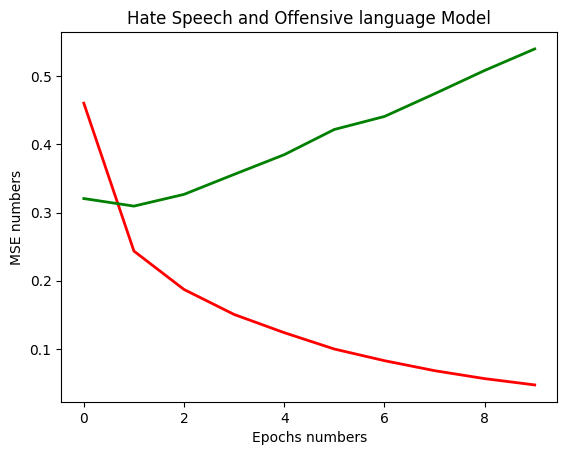

In [ ]:
import matplotlib.pyplot as plt
hist = model.history.history
plt.plot(hist['loss'],'r',linewidth=2, label='Training loss')
plt.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('Hate Speech and Offensive language Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [ ]:
!git clone https://github.com/Mukesh2808/hate-speech-detection.git


fatal: destination path 'hate-speech-detection' already exists and is not an empty directory.


In [ ]:
%cd hate-speech-detection

/content/hate-speech-detection/hate-speech-detection


In [ ]:
!git checkout -b colab-upload

Switched to a new branch 'colab-upload'


In [ ]:
!cp /content/Hate_Speech_Detection.ipynb .

cp: cannot stat '/content/Hate_Speech_Detection.ipynb': No such file or directory


In [ ]:
!git add Hate_Speech_Detection.ipynb

fatal: pathspec 'Hate_Speech_Detection.ipynb' did not match any files


In [ ]:
# Copy your notebook file to the repository directory
# Replace 'Your_Notebook_Name.ipynb' with the actual name of your notebook file
!cp /content/Hate_Speech_Detection.ipynb .

cp: cannot stat '/content/Hate_Speech_Detection.ipynb': No such file or directory


In [ ]:
!git add .
!git commit -m "Add notebook and related files"
!git push origin colab-upload # or your desired branch name

On branch colab-upload

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec colab-upload does not match any
error: failed to push some refs to 'https://github.com/Mukesh2808/hate-speech-detection.git'


In [ ]:
!git add .
!git commit -m "Add notebook and related files"
!git push origin colab-upload # or your desired branch name

On branch colab-upload

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec colab-upload does not match any
error: failed to push some refs to 'https://github.com/Mukesh2808/hate-speech-detection.git'


In [ ]:
!git push --set-upstream origin colab-upload

error: src refspec colab-upload does not match any
error: failed to push some refs to 'https://github.com/Mukesh2808/hate-speech-detection.git'


In [ ]:
!git clone https://github.com/Mukesh2808/hate-speech-detection.git

Cloning into 'hate-speech-detection'...


In [ ]:
# Copy your notebook file to the repository directory
# Replace 'Hate_Speech_Detection.ipynb' with the actual name of your notebook file if it's different
!cp /content/Hate_Speech_Detection.ipynb /content/hate-speech-detection/

cp: cannot stat '/content/Hate_Speech_Detection.ipynb': No such file or directory


In [ ]:
# Copy the notebook file into the repository directory
!cp /content/hate-speech-detection.ipynb /content/hate-speech-detection/

cp: cannot stat '/content/hate-speech-detection.ipynb': No such file or directory
